# Experiments on for "Predicting Individual Independence and Interdependence Orientations Using Dynamic Efficiency of whole-brain functional networks"

## Step 1: load data and preprocessing

In [1]:
import numpy as np
import pickle
import pandas as pd
import datetime
import json
import scipy.stats
import random
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.feature_selection import f_regression, mutual_info_regression, RFE, SelectPercentile, SelectKBest
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

#Load dataset
fmri_data = pickle.load(open('./vec_dynamic_fmri.pickle','rb'))
cog_inde = pickle.load(open('./label_inde.pickle','rb'))
cog_inter = pickle.load(open('./label_inter.pickle','rb'))
cog_D=cog_inde - cog_inter
print(cog_inde)
print(cog_inter)
print(cog_D.shape)
print(cog_inde.shape)
print(fmri_data.shape)

print(fmri_data[15])
print(cog_inde[20])
print(cog_inter[20])

print('data loaded.')

[ 96.  85.  81.  70.  72.  66.  69.  94.  65.  74.  66.  67.  85.  57.
  73.  64.  83.  61.  77.  72.  80.  57.  67.  68.  72.  63.  70.  66.
  59.  72.  47.  71.  66.  90.  85.  73.  55.  68.  78.  75.  67.  83.
  73.  73.  80.  65.  77.  68.  76.  79.  58.  81.  79.  60.  63.  78.
  70.  62.  79.  66.  98.  75.  76.  79.  82.  62.  70.  63.  70.  69.
  61.  61.  72.  73.  79.  70.  71.  71.  82.  93.  66.  76.  68.  83.
  79.  58.  69.  73.  71.  57.  74.  74.  79.  87.  65.  72.  65.  84.
  66.  74.  54.  57.  78.  53.  69.  91.  74.  44.  77.  56.  76.  80.
  65.  67.  79.  71.  59.  57.  69.  57.  66.  66.  80.  78.  64.  59.
  86.  60.  68.  76.  76.  68.  70.  88.  66.  71.  62.  53.  72.  82.
  92.  70.  56.  58.  62.  67.  70.  85.  63.  96.  70.  89.  62.  74.
 102.  80.  80.  59.  94.  71.  71.  67.  70.  63.  80.  67.  70.  79.
  74.  73.  87.  68.  72.  58.  61.  63.  61.  85.  83.  83.  66.  67.
  75.  82.  82.  66.  81.  77.  83.  63.  74.  83.  72.  82.  83.  69.
  62. 

In [2]:
X_general = np.zeros(shape=(fmri_data.shape[0],fmri_data.shape[1]),dtype=np.float32)
for i in range(0,fmri_data.shape[0]):
    for j in range(0,fmri_data.shape[1]):
        X_general[i][j] = fmri_data[i][j]
print(X_general.shape)
print("features merged.")
X_general[np.isnan(X_general)]=0
print(X_general)

(323, 30135)
features merged.
[[ 0.8528905   0.89276797  0.724996   ...  0.8321411   0.93881816
   0.76340616]
 [ 0.6478197  -0.18357994  0.29073936 ...  0.02391877  0.8688775
   0.8145472 ]
 [ 0.9955504   0.8980978   0.91329795 ...  0.94610184  0.942119
   0.98462105]
 ...
 [ 0.6962368   0.39618877 -0.30794212 ...  0.5714469   0.7993826
   0.16650563]
 [ 0.84000546  0.5752897   0.7109888  ...  0.8270366   0.82763046
   0.76895165]
 [ 0.89649624  0.22473212  0.11482399 ...  0.92378896  0.81391823
   0.96673614]]


In [3]:
#name of loaded nodes

brain_nodes = json.load(open('./fMRI_DTI_matrix_359_with_inde_inter/node_label_json.txt'))
#print(brain_nodes[1])

def load_node_file_for_brain_network_viewer():
    full_node_file_name = './Node_BNA246.node'
    node_info = []
    with open(full_node_file_name,'r') as all_node_file:
        for each_node in all_node_file:
            items = each_node.split('\t')
            one_node_info = {'x': items[0], 'y': items[1], 'z':items[2], 'color': items[3], 'size': items[4], 'label':items[5]}
            node_info.append(one_node_info)
    return node_info

#生成脑连接图所需要的信息,brain_nodes为试验中脑区的学名，node_info为该脑结点的信息
def generate_data_for_brain_network_viewer(nodes, edges, brain_nodes, node_info, dti_or_fmri, inde_or_inter, item_limit):
    node_file_name = './generated_nodes_' + inde_or_inter + '_' + dti_or_fmri + '_' + item_limit + '.node'
    edge_file_name = './generated_edges_' + inde_or_inter + '_' + dti_or_fmri + '_' + item_limit + '.edge'
    with open(node_file_name,'w') as node_file:
        node_num = len(nodes)
        node_count = 0
        for each_node in nodes:
            #idx = node_info.index(each_node)
            node_size = 5 - (node_count / node_num) * 4
            node_file.write(node_info[each_node]['x'] + '\t' + node_info[each_node]['y'] + '\t' + node_info[each_node]['z'] + '\t' + node_info[each_node]['color'] + '\t' + str(node_size) + '\t' + node_info[each_node]['label'])
            node_count += 1
    edge_matrix = np.zeros(shape=(len(nodes),len(nodes)))
    amount = len(edge_file_name)
    count = 0
    for each_edge in edges:
        weight = 1.8 - count / amount
        edge_matrix[each_edge[0]][each_edge[1]] = weight
        edge_matrix[each_edge[1]][each_edge[0]] = weight
        count += 1
    with open(edge_file_name,'w') as edge_file:
        for i in range(edge_matrix.shape[0]):
            for j in range(edge_matrix.shape[1]):
                edge_file.write(str(edge_matrix[i][j]) + '\t')
            edge_file.write('\n')
    print('data for brain network generated.')

def find_position_name(position):
    return (brain_nodes[position[0]],brain_nodes[position[1]])

#给出一个输入，得到其所属于的矩阵位置
def FindPosition(M):
    #intype = int
    #rtype = list[int, int]
    flag = "fMRI"
    if(M>30135):
        M -= 30135
        flag = "DTI"
    x = 0
    y = 0
    Row_FirstNum = 1
    while M >= Row_FirstNum:
        x += 1
        Row_FirstNum = (x*x)/2 + x/2 + 1
    x -= 1
    Row_FirstNum = (x * x) / 2 + x / 2 + 1
    y = int(M-Row_FirstNum)
    return (x+1, y,flag)


print(FindPosition(1))
print(find_position_name(FindPosition(1)))

standard_nodes = load_node_file_for_brain_network_viewer()

(1, 0, 'fMRI')
('SFG_R_7_1', 'SFG_L_7_1')


In [4]:
def intersection_feature(section_a, section_b):
    inter_section = list(set(section_a) & set(section_b))
    print(len(inter_section),'features co-occur')


def transform(original_feature, idx_kept):
    result = np.zeros((original_feature.shape[0], len(idx_kept)))
    for i, each_idx in enumerate(idx_kept):
        for j in range(original_feature.shape[0]):
            result[j][i] = original_feature[j][each_idx]
    return result


def coef_fit_transform(coef_info, original_feature, threhold=0.25):
    idx_kept = []
    count = 0
    feature_mask = []
    for i, each_coef in enumerate(coef_info):
        if each_coef >= threhold:
            count += 1
            idx_kept.append(i)
            feature_mask.append(True)
        else:
            feature_mask.append(False)
    result = transform(original_feature, idx_kept)
    print(len(idx_kept),'features selected in this time.')
    #intersection_feature(idx_kept, features_number_inde)
    return result, feature_mask

def r_regression(X, y):
    coef = np.zeros((X.shape[1]))
    for j in range(X.shape[1]):
        coef[j] = scipy.stats.spearmanr(X[:,j], y)[0]
    return coef

In [5]:
#Revision: 10-Fold-cross-validation for independent self-construal prediction

kf=KFold(n_splits=10,shuffle=False, random_state=321)    # 定义分成几个组
inner_cv = KFold(n_splits=10, shuffle=False, random_state=123)
nested_predict_inde = []
true_value_inde = []
feature_coef_inde = []

for train_index,test_index in kf.split(X_general):
    print("Prcessing Fold:",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    #print("Train Index:",train_index,",Test Index:",test_index) 
    X_train,X_test=X_general[train_index],X_general[test_index] #X_features_inde
    y_train,y_test=cog_inde[train_index],cog_inde[test_index]
    #X_features_inde X_general
    
    #estimator = Lasso(alpha=100)
    #selector = RFE(estimator, n_features_to_select=5000, step=20)
    #selector = SelectPercentile(f_regression, percentile=100)
    #selected_X_train = selector.fit_transform(X_train, y_train)
    #selected_X_test = selector.transform(X_test)
    #print(selector.support_)
    #mi = mutual_info_regression(X_train, y_train)
    #f_test, pval = f_regression(X_train, y_train)
    r_test = r_regression(X_train, y_train)
    #f_test /= np.max(f_test)
    selected_X_train, feature_mask = coef_fit_transform(r_test, X_train, 0.05)
    selected_X_test, _ = coef_fit_transform(r_test, X_test, 0.05)
    
    lr = GridSearchCV(estimator=Lasso(random_state=123456), 
                       param_grid={"alpha": [1, 1e2,3e2,5e2],
                                  "max_iter": [1000,1500,10000],
                                  "fit_intercept":[True, False]},
                       cv=inner_cv)
    rr = GridSearchCV(estimator=Ridge(solver='auto',random_state=123456), 
                       param_grid={"alpha": [1e-3, 1e-2, 1e-1, 1, 1e2,3e2,5e2],
                                  "max_iter": [300,500,1000,1500,None]},
                       cv=inner_cv)
    svr = GridSearchCV(estimator=SVR(),
                   param_grid={"C": [3e-3, 3e-2, 3e-1, 1e0, 1e1, 1e2, 1e3],
                               "kernel": ['linear','rbf'],
                               "gamma":[0.2, 0.4, 0.5, 0.6, 1.0]
                              },
                   cv=inner_cv)
    xgb_reg = XGBRegressor(learning_rate=0.05, max_depth=4, n_estimators=600, objective='reg:squarederror',gamma=0.3)
    xgb = GridSearchCV(estimator=xgb_reg,
                   param_grid={"learning_rate": [0.01, 0.015, 0.025, 0.03, 0.05, 0.1],
                               "max_depth": [3,4,5,6],
                               "n_estimators":[50, 100, 160, 300,600],
                               'objective':['reg:squarederror','reg:gamma'],#,
                               'subsample': [0.7,1.0],
                              },
                   cv=10,refit=True, n_jobs=-1)
    xgb_reg.fit(selected_X_train, y_train)
    #predicted_y = np.around(xgb.predict(selected_X_test))
    predicted_y = xgb_reg.predict(selected_X_test)
    temp_coef = xgb_reg.feature_importances_
    
    coef_in_this_round = np.zeros((len(feature_mask)))
    count_used_coef = 0
    for i in range(len(feature_mask)):
        if feature_mask[i] == True:
            coef_in_this_round[i] = temp_coef[count_used_coef]
            count_used_coef += 1
        else:
            pass
    feature_coef_inde.append(coef_in_this_round)
            
    #print(len(predicted_y),":",predicted_y)
    #print(len(y_test),":",y_test)
    print('Current Performance: MAE=', mean_absolute_error(y_test,predicted_y), '; MSE=:', mean_squared_error(y_test,predicted_y), '; r=',scipy.stats.spearmanr(y_test, predicted_y))
    nested_predict_inde.extend(predicted_y)
    true_value_inde.extend(y_test)
    
    
feature_coef_inde = np.array(feature_coef_inde)  
print('final MAE=', mean_absolute_error(true_value_inde,nested_predict_inde), '; MSE=:', mean_squared_error(true_value_inde,nested_predict_inde), '; r=',scipy.stats.spearmanr(nested_predict_inde, true_value_inde))
print("Done at:",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Prcessing Fold: 2021-04-07 20:52:36
998 features selected in this time.
998 features selected in this time.
Current Performance: MAE= 8.247643441864938 ; MSE=: 97.30664908594035 ; r= SpearmanrResult(correlation=0.362190952222643, pvalue=0.03832886041995385)
Prcessing Fold: 2021-04-07 20:52:59
736 features selected in this time.
736 features selected in this time.
Current Performance: MAE= 7.176058566931522 ; MSE=: 72.84733830193088 ; r= SpearmanrResult(correlation=0.4638050888092919, pvalue=0.006554773523575528)
Prcessing Fold: 2021-04-07 20:53:20
736 features selected in this time.
736 features selected in this time.
Current Performance: MAE= 6.54172354033499 ; MSE=: 67.95311852701883 ; r= SpearmanrResult(correlation=0.3647171737695587, pvalue=0.03690186901777773)
Prcessing Fold: 2021-04-07 20:53:42
2488 features selected in this time.
2488 features selected in this time.
Current Performance: MAE= 9.879833936691284 ; MSE=: 151.6337920295573 ; r= SpearmanrResult(correlation=0.052486738

In [6]:
#Revision: 10-Fold-cross-validation for interpendent self-construal prediction
kf=KFold(n_splits=10,shuffle=False, random_state=321)    # 定义分成几个组
inner_cv = KFold(n_splits=10, shuffle=False, random_state=123)
nested_predict_inter = []
true_value_inter = []
feature_coef_inter = []

for train_index,test_index in kf.split(X_general):
    print("Prcessing Fold:",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    #print("Train Index:",train_index,",Test Index:",test_index) 
    X_train,X_test=X_general[train_index],X_general[test_index] #X_features_inde
    y_train,y_test=cog_inter[train_index],cog_inter[test_index]
    #X_features_inde X_general
    
    #estimator = Lasso(alpha=100)
    #selector = RFE(estimator, n_features_to_select=5000, step=20)
    #selector = SelectPercentile(f_regression, percentile=100)
    #selected_X_train = selector.fit_transform(X_train, y_train)
    #selected_X_test = selector.transform(X_test)
    #print(selector.support_)
    #mi = mutual_info_regression(X_train, y_train)
    #f_test, pval = f_regression(X_train, y_train)
    r_test = r_regression(X_train, y_train)
    #f_test /= np.max(f_test)
    selected_X_train, feature_mask = coef_fit_transform(r_test, X_train, 0.03)
    selected_X_test, _ = coef_fit_transform(r_test, X_test, 0.03)
    
    lr = GridSearchCV(estimator=Lasso(random_state=123456), 
                       param_grid={"alpha": [1, 1e2,3e2,5e2],
                                  "max_iter": [1000,1500,10000],
                                  "fit_intercept":[True, False]},
                       cv=inner_cv)
    rr = GridSearchCV(estimator=Ridge(solver='auto',random_state=123456), 
                       param_grid={"alpha": [1e-3, 1e-2, 1e-1, 1, 1e2,3e2,5e2],
                                  "max_iter": [300,500,1000,1500,None]},
                       cv=inner_cv)
    svr = GridSearchCV(estimator=SVR(),
                   param_grid={"C": [3e-3, 3e-2, 3e-1, 1e0, 1e1, 1e2, 1e3],
                               "kernel": ['linear','rbf'],
                               "gamma":[0.2, 0.4, 0.5, 0.6, 1.0]
                              },
                   cv=inner_cv)
    xgb_reg = XGBRegressor(learning_rate=0.05, max_depth=6, n_estimators=1200, objective='reg:gamma')
    xgb = GridSearchCV(estimator=xgb_reg,
                   param_grid={"learning_rate": [0.01, 0.015, 0.025, 0.03, 0.05, 0.1],
                               "max_depth": [3,4,5,6],
                               "n_estimators":[50, 100, 160, 300,600],
                               'objective':['reg:squarederror','reg:gamma'],#,
                               'subsample': [0.7,1.0],
                              },
                   cv=10,refit=True, n_jobs=-1)
    xgb_reg.fit(selected_X_train, y_train)
    #predicted_y = np.around(xgb.predict(selected_X_test))
    predicted_y = xgb_reg.predict(selected_X_test)
    temp_coef = xgb_reg.feature_importances_
    
    coef_in_this_round = np.zeros((len(feature_mask)))
    count_used_coef = 0
    for i in range(len(feature_mask)):
        if feature_mask[i] == True:
            coef_in_this_round[i] = temp_coef[count_used_coef]
            count_used_coef += 1
        else:
            pass
    feature_coef_inter.append(coef_in_this_round)
    
    #print(len(predicted_y),":",predicted_y)
    #print(len(y_test),":",y_test)
    print('Current Performance: MAE=', mean_absolute_error(y_test,predicted_y), '; MSE=:', mean_squared_error(y_test,predicted_y), '; r=',scipy.stats.spearmanr(y_test, predicted_y))
    nested_predict_inter.extend(predicted_y)
    true_value_inter.extend(y_test)
    
    
feature_coef_inter = np.array(feature_coef_inter)  
print('final MAE=', mean_absolute_error(true_value_inter,nested_predict_inter), '; MSE=:', mean_squared_error(true_value_inter,nested_predict_inter), '; r=',scipy.stats.spearmanr(nested_predict_inter, true_value_inter))
print("Done at:",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Prcessing Fold: 2021-04-07 20:56:36
13201 features selected in this time.
13201 features selected in this time.
Current Performance: MAE= 7.12333887273615 ; MSE=: 84.92003555139209 ; r= SpearmanrResult(correlation=0.33548089663695524, pvalue=0.056312533921280945)
Prcessing Fold: 2021-04-07 20:58:21
8716 features selected in this time.
8716 features selected in this time.
Current Performance: MAE= 6.142083370324337 ; MSE=: 73.27074123569676 ; r= SpearmanrResult(correlation=0.27367962097843185, pvalue=0.12328221933659872)
Prcessing Fold: 2021-04-07 20:59:35
11341 features selected in this time.
11341 features selected in this time.
Current Performance: MAE= 8.116203886089902 ; MSE=: 93.69057769153953 ; r= SpearmanrResult(correlation=0.03469385575955005, pvalue=0.8479977289445868)
Prcessing Fold: 2021-04-07 21:01:08
10445 features selected in this time.
10445 features selected in this time.
Current Performance: MAE= 8.22050142288208 ; MSE=: 93.77827792979588 ; r= SpearmanrResult(correlati

## Analysis on prediction and model outputted coefficents

### Correlation map

<Figure size 1152x1152 with 0 Axes>

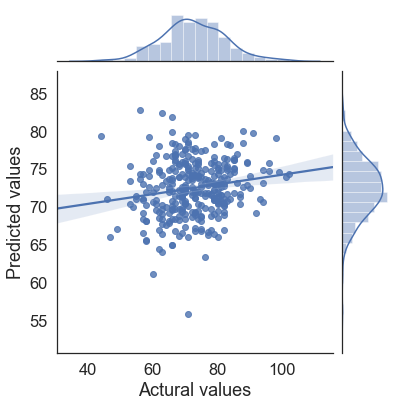

In [8]:
%matplotlib inline
sns.set(style="white", color_codes=True, font_scale=1.5)

inde_plot_results = {'Predicted values': nested_predict_inde, 'Actural values': true_value_inde}
inde_plot_results = pd.DataFrame(inde_plot_results)

plt.figure(figsize=(16,16))
g = sns.jointplot("Actural values", "Predicted values", data=inde_plot_results, kind="reg")
plt.savefig("subplot_inde.png",dpi=300)
plt.show()

<Figure size 1152x1152 with 0 Axes>

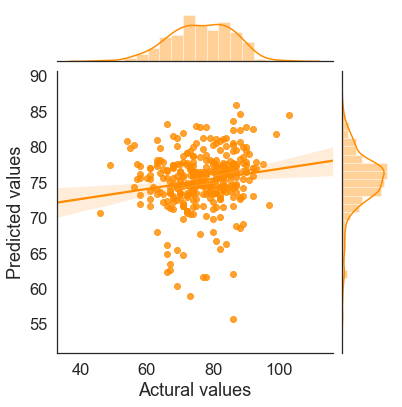

In [9]:
sns.set(style="white", color_codes=True, font_scale=1.5)

inter_plot_results = {'Predicted values': nested_predict_inter, 'Actural values': true_value_inter}
inter_plot_results = pd.DataFrame(inter_plot_results)

plt.figure(figsize=(16,16))
g = sns.jointplot("Actural values", "Predicted values",data=inter_plot_results, kind="reg", color = 'darkorange')
plt.savefig("subplot_inter.png",dpi=300)
plt.show()

### Importance Analysis on Connections

In [10]:
def find_top_k_connections(coef_vector, brain_nodes, standard_nodes, SC_type, top_k = 10):
    nodes_id_for_plot = []
    edges_pair_for_plot = []
    link_pairs_with_names = []
    link_pairs = []
    count_left = 0
    count_right = 0
    count_cross = 0
    top_k_idx=np.abs(coef_vector).argsort()[::-1][0:top_k]
    if top_k == 20:
        print("##,feature_idx,  original_idx,        position,         coef,       area")
    for counter, each_idx in enumerate(top_k_idx):
        if top_k == 20:
            print(counter, ",", each_idx,",", each_idx, 
                  ',', FindPosition(each_idx+1),',', 
                  coef_vector[each_idx], find_position_name(FindPosition(each_idx+1)))
        
        one_link = FindPosition(each_idx+1)
        link_pairs.append((one_link[0], one_link[1], coef_vector[each_idx]))
        node_id_temp = [-1,-1]
        
        for j in range(0,2):
            if one_link[j] not in nodes_id_for_plot:
                nodes_id_for_plot.append(one_link[j])
            else:
                pass
            node_id_temp[j] = nodes_id_for_plot.index(one_link[j])
        edges_pair_for_plot.append((node_id_temp[0],node_id_temp[1]))
        
        two_areas = find_position_name(FindPosition(each_idx+1))
        link_pairs_with_names.append((two_areas[0], two_areas[1], each_idx))
        area_position = ['1', '1']
        area_position[0] = two_areas[0].split('_')[1]
        area_position[1] = two_areas[1].split('_')[1]
        if area_position[0] == 'L' and area_position[1] == 'L':
            count_left += 1
        elif area_position[0] == 'R' and area_position[1] == 'R':
            count_right += 1
        elif area_position[0] == 'L' and area_position[1] == 'R':
            count_cross += 1
        elif area_position[0] == 'R' and area_position[1] == 'L':
            count_cross += 1
        else:
            print('error in finding LR.')
        
    generate_data_for_brain_network_viewer(nodes_id_for_plot,edges_pair_for_plot,brain_nodes,
                                           standard_nodes, 'fMRI', SC_type, str(top_k))
    print("node and link files for ", SC_type, "with top ", top_k, 'records is saved.')
    print("[Counter Info] left vs. cross vs. right:", count_left, ':', count_cross, ':', count_right)
    return link_pairs_with_names, link_pairs
        

In [11]:
coefs_inde = np.zeros((feature_coef_inde.shape[0], feature_coef_inde.shape[1]))
coef_inde_mean = np.zeros(feature_coef_inde.shape[1])

coefs_inde_source = np.zeros((11, feature_coef_inde.shape[1]))
links_inde = []

for i in range(0, feature_coef_inde.shape[0]):
    temp_array = []
    for each_number in feature_coef_inde[i]:
        if each_number != 0:
            temp_array.append(each_number)
    temp_array = np.array(temp_array)
    min_temp = np.min(temp_array)
    max_temp =np.max(temp_array)
    #print('max:',max_temp)
    #print('min:',min_temp)
    # feature_coef_inde
    coefs_inde[i] = (feature_coef_inde[i] - min_temp) / (max_temp - min_temp)
    # coefs_inde_source[count] = np.array(clf.coef_)
#print(coefs_inde)

for each_dimension in range(coefs_inde.shape[1]):
    coef_inde_mean[each_dimension] = np.mean(coefs_inde[:,each_dimension])
    #features_number_inde = 
#print(len(features_number_inde))
#print(coef_inde_mean.shape)
connections_inde = []
for top_k in [10,20,30,40,50]:
    print(top_k)
    names, pairs = find_top_k_connections(coef_inde_mean, brain_nodes, standard_nodes, 'inde', top_k)
    connections_inde.append(names)
    links_inde.append(pairs)

10
data for brain network generated.
node and link files for  inde with top  10 records is saved.
[Counter Info] left vs. cross vs. right: 1 : 4 : 5
20
##,feature_idx,  original_idx,        position,         coef,       area
0 , 19819 , 19819 , (199, 118, 'fMRI') , 0.3698336197824231 ('LOcC_R_4_1', 'PhG_L_6_6')
1 , 11988 , 11988 , (155, 53, 'fMRI') , 0.34199361693237934 ('PoG_R_4_1', 'PrG_R_6_1')
2 , 27991 , 27991 , (237, 25, 'fMRI') , 0.3399260994872081 ('Tha_R_8_4', 'MFG_R_7_6')
3 , 21312 , 21312 , (206, 197, 'fMRI') , 0.3270128087902499 ('LOcC_L_2_1', 'MVOcC_R_5_5')
4 , 12650 , 12650 , (159, 89, 'fMRI') , 0.2899659798460933 ('PoG_R_4_3', 'ITG_R_7_1')
5 , 19621 , 19621 , (198, 118, 'fMRI') , 0.2637571271911482 ('LOcC_L_4_1', 'PhG_L_6_6')
6 , 5031 , 5031 , (100, 81, 'fMRI') , 0.26339471439638307 ('ITG_L_7_7', 'MTG_R_4_1')
7 , 20577 , 20577 , (203, 74, 'fMRI') , 0.23980979808475608 ('LOcC_R_4_3', 'STG_L_6_4')
8 , 14241 , 14241 , (169, 45, 'fMRI') , 0.2384135094166921 ('INS_R_6_4', 'OrG

In [12]:
coefs_inter = np.zeros((feature_coef_inter.shape[0], feature_coef_inter.shape[1]))
coef_inter_mean = np.zeros(feature_coef_inter.shape[1])

coefs_inter_source = np.zeros((11, feature_coef_inter.shape[1]))
links_inter = []

for i in range(0, feature_coef_inter.shape[0]):
    temp_array = []
    for each_number in feature_coef_inter[i]:
        if each_number != 0:
            temp_array.append(each_number)
    temp_array = np.array(temp_array)
    min_temp = np.min(temp_array)
    max_temp =np.max(temp_array)
    #print('max:',max_temp)
    #print('min:',min_temp)
    coefs_inter[i] = (feature_coef_inter[i] - min_temp) / (max_temp - min_temp)
    # coefs_inter_source[count] = np.array(clf.coef_)
#print(coefs_inter)

for each_dimension in range(coefs_inde.shape[1]):
    coef_inter_mean[each_dimension] = np.mean(coefs_inter[:,each_dimension])
#print(len(features_number_inter))
#print(coef_inter_mean.shape)
connections_inter = []
for top_k in [10,20,30,40,50]:
    print(top_k)
    names, pairs = find_top_k_connections(coef_inter_mean, brain_nodes, standard_nodes, 'inter', top_k)
    connections_inter.append(names)
    links_inter.append(pairs)

10
data for brain network generated.
node and link files for  inter with top  10 records is saved.
[Counter Info] left vs. cross vs. right: 6 : 3 : 1
20
##,feature_idx,  original_idx,        position,         coef,       area
0 , 19615 , 19615 , (198, 112, 'fMRI') , 0.6039022602865758 ('LOcC_L_4_1', 'PhG_L_6_3')
1 , 27357 , 27357 , (234, 96, 'fMRI') , 0.5201288134626525 ('Tha_L_8_3', 'ITG_L_7_5')
2 , 22239 , 22239 , (211, 84, 'fMRI') , 0.44863338309269807 ('Amyg_R_2_1', 'MTG_L_4_3')
3 , 6712 , 6712 , (116, 42, 'fMRI') , 0.4224261801482518 ('PhG_L_6_5', 'OrG_L_6_2')
4 , 6782 , 6782 , (116, 112, 'fMRI') , 0.4030976636376664 ('PhG_L_6_5', 'PhG_L_6_3')
5 , 29339 , 29339 , (242, 178, 'fMRI') , 0.38603874133065313 ('Tha_L_8_7', 'CG_L_7_3')
6 , 25677 , 25677 , (227, 26, 'fMRI') , 0.3705780898030105 ('BG_R_6_5', 'MFG_L_7_7')
7 , 28654 , 28654 , (239, 213, 'fMRI') , 0.3699749694898212 ('Tha_R_8_5', 'Amyg_R_2_2')
8 , 28050 , 28050 , (237, 84, 'fMRI') , 0.3641224977107938 ('Tha_R_8_4', 'MTG_L_4_3

### Coef Map

In [13]:
import nibabel as nib
import json
import time

def load_template_to_memory(dir_source, start_roi=1, end_roi=246):
    roi_templates = []
    for i in range(start_roi, end_roi+1):
        loaded_nii = nib.load(dir_source+str(i) + '.nii.gz')
        # print(loaded_nii.affine)
        image_data = loaded_nii.get_data()
        roi_templates.append(image_data / np.max(image_data))
    print(len(roi_templates)," templates are loaded into the memeory.")
    return roi_templates


def merge_nii_plus(nii_source, nii_target, weight):
    #nii_source * weight + nii_target -> nii_target
    if nii_source.shape != nii_target.shape:
        print("shapes are not same!")
        return nii_target
    result = nii_source / np.max(nii_source) * weight + nii_target
    return result

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
dir_roi = './atlas/PM/'
roi_templates = load_template_to_memory(dir_roi)

246  templates are loaded into the memeory.


In [15]:
target_dir = './'
affine = nib.load('./atlas/test.nii.gz').affine
truples = links_inde[-1]

print(truples)

print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 
nii = np.zeros(shape=(145, 173, 145))
count = 0
print(len(truples), 'records in total.')
for each_truple in truples:
    count += 1
    if count % 100 == 0:
        print('process:', count)
    nii = merge_nii_plus(roi_templates[each_truple[0]], nii, each_truple[2])
    nii = merge_nii_plus(roi_templates[each_truple[1]], nii, each_truple[2])
    
new_image = nib.Nifti1Image(nii, affine)
nib.save(new_image, target_dir + 'inde_coef_map.nii.gz')
#selected_dict
print('done.')
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 

[(199, 118, 0.3698336197824231), (155, 53, 0.34199361693237934), (237, 25, 0.3399260994872081), (206, 197, 0.3270128087902499), (159, 89, 0.2899659798460933), (198, 118, 0.2637571271911482), (100, 81, 0.26339471439638307), (203, 74, 0.23980979808475608), (169, 45, 0.2384135094166921), (183, 71, 0.22516017931592786), (241, 141, 0.22394742527714614), (237, 117, 0.22135393357692257), (169, 75, 0.22110112254673445), (225, 173, 0.2050813564557612), (226, 167, 0.1995000017532485), (120, 89, 0.1969730099214043), (215, 95, 0.19525755439866863), (199, 197, 0.19447534860300367), (158, 32, 0.19221557938302739), (75, 71, 0.19199340008141189), (145, 71, 0.19180152371459078), (182, 71, 0.18804953325823592), (165, 89, 0.18335796169969493), (89, 71, 0.1830563035543718), (171, 93, 0.1817258006729935), (243, 140, 0.18074532079925706), (112, 97, 0.17934583061438208), (237, 7, 0.1793457233740933), (89, 51, 0.1788898201716303), (100, 27, 0.1767563014765567), (213, 89, 0.17455797131229728), (116, 46, 0.1738

In [16]:
target_dir = './'
affine = nib.load('./atlas/test.nii.gz').affine
truples = links_inter[-1]

#print(truples)

print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 
nii = np.zeros(shape=(145, 173, 145))
count = 0
print(len(truples), 'records in total.')
for each_truple in truples:
    count += 1
    if count % 100 == 0:
        print('process:', count)
    nii = merge_nii_plus(roi_templates[each_truple[0]], nii, each_truple[2])
    nii = merge_nii_plus(roi_templates[each_truple[1]], nii, each_truple[2])
    
new_image = nib.Nifti1Image(nii, affine)
nib.save(new_image, target_dir + 'inter_coef_map.nii.gz')
#selected_dict
print('done.')
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 

2021-04-07 21:10:45
50 records in total.
done.
2021-04-07 21:10:49


In [17]:
import scipy.io

inde_for_chrod = np.zeros(shape=(246,246))
inter_for_chrod = np.zeros(shape=(246,246))

for each_link in links_inde[1]:
    inde_for_chrod[each_link[0]-1][each_link[1]-1] = each_link[2]
    inde_for_chrod[each_link[1]-1][each_link[0]-1] = each_link[2]

for each_link in links_inter[1]:
    inter_for_chrod[each_link[0]-1][each_link[1]-1] = each_link[2]
    inter_for_chrod[each_link[1]-1][each_link[0]-1] = each_link[2]

scipy.io.savemat('./XGBoost_coef_for_chrod_inde.mat', mdict={'Ridge_inde': np.abs(inde_for_chrod)})
scipy.io.savemat('./XGBoost_coef_for_chrod_inter.mat', mdict={'Ridge_inter': np.abs(inter_for_chrod)})   
print('done.')

done.


### Save data and more statistics

In [20]:
pickle.dump(nested_predict_inde, open('nested_predicted_values_inde_dynamic.pkl', 'wb'))
pickle.dump(nested_predict_inter, open('nested_predicted_values_inter_dynamic.pkl', 'wb'))

In [22]:
from scipy.stats import chisquare
import numpy as np
inde_top_count = np.array([2, 6, 2])
inter_top_count = np.array([3, 6, 1])
chisquare_value, pvalue = chisquare(inde_top_count, inter_top_count)
print("Top 10 Chi-Square:", chisquare_value, pvalue)

inde_top_count = np.array([5, 7, 8])
inter_top_count = np.array([4, 13, 3])
chisquare_value, pvalue = chisquare(inde_top_count, inter_top_count)
print("Top 20 Chi-Square:", chisquare_value, pvalue)

inde_top_count = np.array([8, 8, 14])
inter_top_count = np.array([5, 22, 3])
chisquare_value, pvalue = chisquare(inde_top_count, inter_top_count)
print("Top 30 Chi-Square:", chisquare_value, pvalue)

inde_top_count = np.array([9, 8, 23])
inter_top_count = np.array([6, 30, 4])
chisquare_value, pvalue = chisquare(inde_top_count, inter_top_count)
print("Top 40 Chi-Square:", chisquare_value, pvalue)

Top 10 Chi-Square: 1.3333333333333333 0.5134171190325922
Top 20 Chi-Square: 11.352564102564102 0.003426273500952833
Top 30 Chi-Square: 51.04242424242425 8.246665977411885e-12
Top 40 Chi-Square: 107.88333333333333 3.74482754005967e-24
